In [106]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import cmcrameri.cm as cm
import time
from skimage.data import binary_blobs

import torch
import torch.nn as nn
import torch.optim as optim
from torch.fft import fftn, ifftn, fftshift, ifftshift

from torchdiffeq import odeint, odeint_adjoint

from utils import cm, format_axis, props
from ode import ODE, Kuramoto, GrayScott, LotkaVolterra

In [41]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time

import torch

from utils import cm, format_axis, props
from ode import ODE, Kuramoto, GrayScott, LotkaVolterra
from cxs import CXSGrid, CXSPoint

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
default_type = torch.float64
torch.set_default_dtype(default_type)

In [3]:
method = 'dopri5'
adjoint = False

In [96]:
import sys, importlib
importlib.reload(sys.modules['cxs'])
importlib.reload(sys.modules['ode'])
#from ode import ODE, Kuramoto, GrayScott, LotkaVolterra
from cxs import CXSGrid, CXSPoint

### Kuramoto

In [4]:
args = {'N': 100,
        'L': 2.,
        'v': 0.5,
        'K': 0.2
       }
M = 5

kuramoto = Kuramoto(args, method)
kuramoto.init_state(M)
kuramoto.to(device)

T = 151
t = torch.linspace(0, T//2, T)
t0 = 50
T -= t0

kuramoto.solve(t)
kuramoto.trim(t0)

Elapsed time: 3.34 s


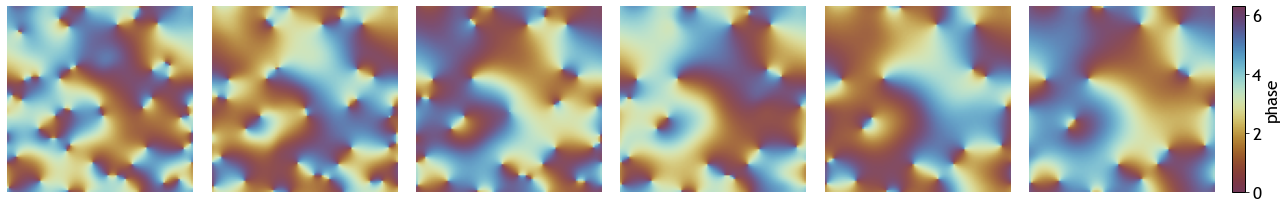

In [5]:
fig = kuramoto.plot_series(kuramoto.y[:,0].cpu().numpy().reshape(-1,kuramoto.N,kuramoto.N),
                           ntype='mod', clabel='phase')

### Gray-Scott

In [6]:
args = {'N': 200,
        'L': 2.,
        'Du': 1e-5,
        'Dv': 5e-6,
        'f': 0.040,
        'k': 0.063,
        'f0': 0.040,
        'k0': 0.060
       }
M = 1

grayscott = GrayScott(args, method)
grayscott.init_state(M)
grayscott.to(device)

tf = 2500
T = 6
t = torch.linspace(0, tf, T)

grayscott.init_solve(t)

Elapsed time: 11.10 s


In [7]:
tf = 250
T = 51
t = torch.linspace(0, tf, T)

grayscott.solve(t)

Elapsed time: 1.42 s


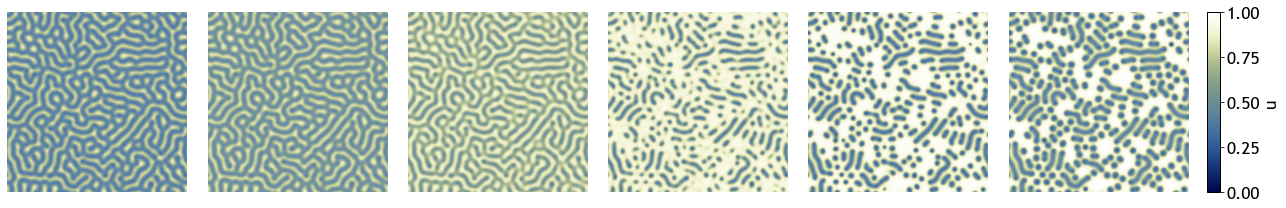

In [8]:
fig = grayscott.plot_series(grayscott.y[:,0,0].cpu().numpy().reshape(-1,grayscott.N,grayscott.N),
                            ntype='unit', clabel='u')

### Lotka-Volterra

In [9]:
args = {'N': 400,
        'L': 2.,
        'R': 0.07,
        'alpha': 1./3,
        'beta': 2./3,
        'gamma': 0.5,
        'delta': 0.5
       }
M = 10

lv = LotkaVolterra(args, method)
lv.init_state(M)
lv.to(device)

T = 151
t = torch.linspace(0, T-1, T)

lv.solve(t)

Elapsed time: 1.03 s


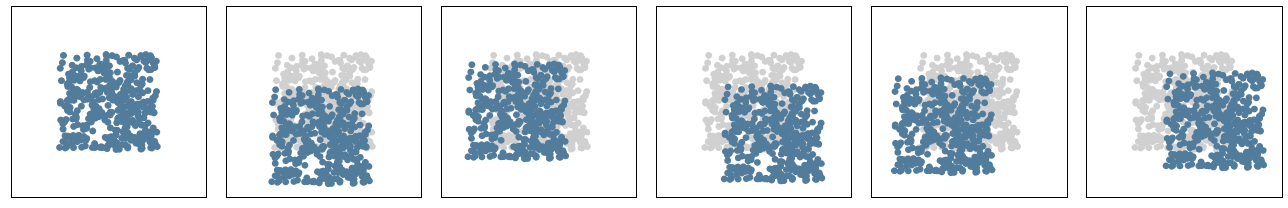

In [10]:
fig = lv.plot_series(lv.y[:,0].cpu().numpy())

### Kuramoto

Detector: 92 x 92 	Probe: 15 x 15
Detector: 92 x 92 	Probe: 9 x 9
Detector: 92 x 92 	Probe: 7 x 7
Detector: 92 x 92 	Probe: 5 x 5
Detector: 80 x 80 	Probe: 13 x 13
Detector: 80 x 80 	Probe: 7 x 7
Detector: 80 x 80 	Probe: 5 x 5
Detector: 80 x 80 	Probe: 5 x 5
Detector: 72 x 72 	Probe: 11 x 11
Detector: 72 x 72 	Probe: 7 x 7
Detector: 72 x 72 	Probe: 5 x 5
Detector: 72 x 72 	Probe: 5 x 5
Detector: 65 x 65 	Probe: 10 x 10
Detector: 65 x 65 	Probe: 6 x 6
Detector: 65 x 65 	Probe: 4 x 4
Detector: 65 x 65 	Probe: 4 x 4


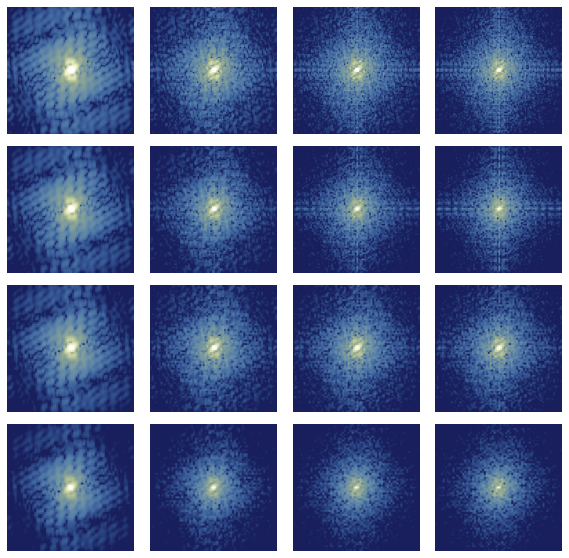

In [104]:
n = 64
f_mask = None
dqs = np.arange(0.7,1.05,0.1)
f_probes = np.arange(0.15,0.5,0.1)

fig, ax = plt.subplots(len(dqs), len(f_probes), figsize=(10,10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for i, dq in enumerate(dqs):
    for j, f_probe in enumerate(f_probes):
        cxs = CXSGrid(kuramoto.N, n, L=kuramoto.L, dq=dq, f_probe=f_probe, f_mask=f_mask, f='phase').to(device)
        kuramoto.plot_frame(ax[i,j], cxs(kuramoto.y0[0], pol=1).reshape(cxs.n, cxs.n),
                            vmin=1e2, vmax=1e8, ntype='log')

Detector: 64 x 64 	Probe: 13 x 13


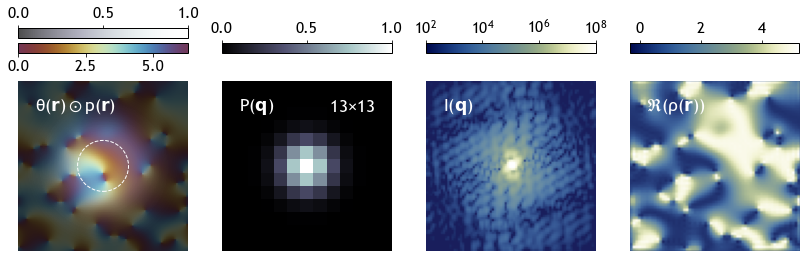

In [52]:
n = 64
dq = 0.8
f_probe = 0.15
f_mask = None
cxs = CXSGrid(kuramoto.N, n, L=kuramoto.L, dq=dq, f_probe=f_probe, f_mask=f_mask, f='phase').to(device)
fig = cxs.plot_example(kuramoto, kuramoto.y0[0], ntype='mod', vmin=1e2, vmax=1e8)

In [42]:
batch_time = 20
batch_size = 10
batch_t, batch_y0, batch_y = kuramoto.get_batch(batch_time, batch_size)
print(' t:', batch_t.shape)
print('y0:', batch_y0.shape)
print(' y:', batch_y.shape)

cxs(batch_y)
ti = time.time()
batch_Y = cxs(batch_y, pol=1)
tf = time.time()
print('Elapsed time: {:.3f} s'.format(tf - ti))

 t: torch.Size([20])
y0: torch.Size([10, 1, 10000])
 y: torch.Size([20, 10, 1, 10000])
Elapsed time: 0.597 s


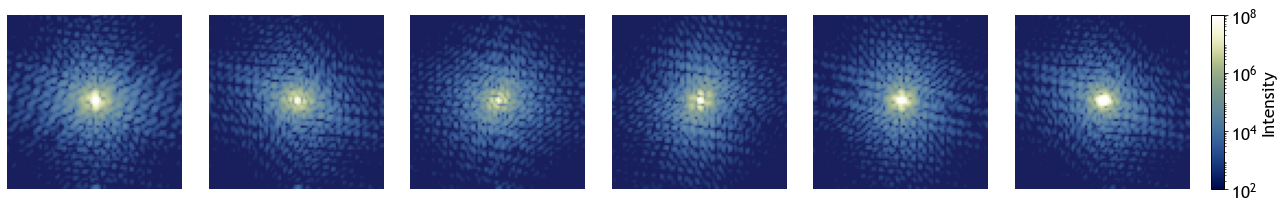

In [43]:
fig = kuramoto.plot_series(batch_Y[:,0].cpu().numpy().reshape(-1,cxs.n,cxs.n),
                           ntype='log', vmin=1e2, vmax=1e8, clabel='Intensity')

### Gray-Scott

Detector: 92 x 92 	Probe: 15 x 15
Detector: 92 x 92 	Probe: 9 x 9
Detector: 92 x 92 	Probe: 7 x 7
Detector: 92 x 92 	Probe: 5 x 5
Detector: 80 x 80 	Probe: 13 x 13
Detector: 80 x 80 	Probe: 7 x 7
Detector: 80 x 80 	Probe: 5 x 5
Detector: 80 x 80 	Probe: 5 x 5
Detector: 72 x 72 	Probe: 11 x 11
Detector: 72 x 72 	Probe: 7 x 7
Detector: 72 x 72 	Probe: 5 x 5
Detector: 72 x 72 	Probe: 5 x 5
Detector: 65 x 65 	Probe: 10 x 10
Detector: 65 x 65 	Probe: 6 x 6
Detector: 65 x 65 	Probe: 4 x 4
Detector: 65 x 65 	Probe: 4 x 4


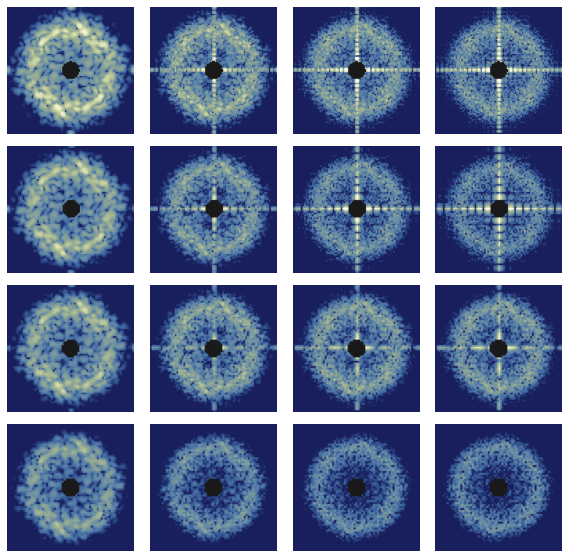

In [103]:
n = 64
f_mask = 0.07
dqs = np.arange(0.7,1.05,0.1)
f_probes = np.arange(0.15,0.5,0.1)

fig, ax = plt.subplots(len(dqs), len(f_probes), figsize=(10,10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for i, dq in enumerate(dqs):
    for j, f_probe in enumerate(f_probes):     
        cxs = CXSGrid(grayscott.N, n, L=grayscott.L, dq=dq, f_probe=f_probe, f_mask=f_mask, f='unit').to(device)
        grayscott.plot_frame(ax[i,j], cxs(grayscott.y0[0], pol=1).reshape(cxs.n, cxs.n),
                             vmin=1e2, vmax=1e6, ntype='log')

Detector: 80 x 80 	Probe: 13 x 13


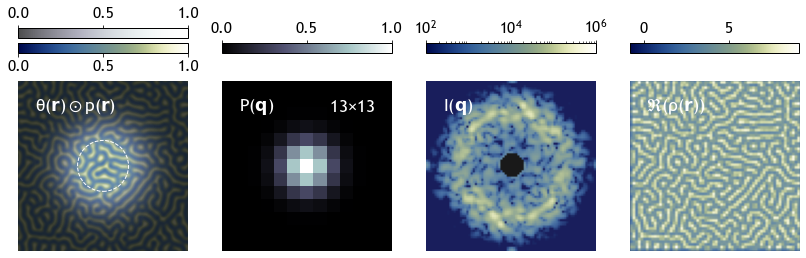

In [102]:
n = 64
dq = 0.8
f_probe = 0.15
f_mask = 0.07
cxs = CXSGrid(grayscott.N, n, L=grayscott.L, dq=dq, f_probe=f_probe, f_mask=f_mask, f='unit').to(device)
fig = cxs.plot_example(grayscott, grayscott.y0[0], ntype='unit', vmin=1e2, vmax=1e6)

In [46]:
batch_time = 20
batch_size = 10
batch_t, batch_y0, batch_y = grayscott.get_batch(batch_time, batch_size)
print(' t:', batch_t.shape)
print('y0:', batch_y0.shape)
print(' y:', batch_y.shape)

cxs(batch_y)
ti = time.time()
batch_Y = cxs(batch_y, pol=1)
tf = time.time()
print('Elapsed time: {:.3f} s'.format(tf - ti))

 t: torch.Size([20])
y0: torch.Size([10, 2, 40000])
 y: torch.Size([20, 10, 2, 40000])
Elapsed time: 1.991 s


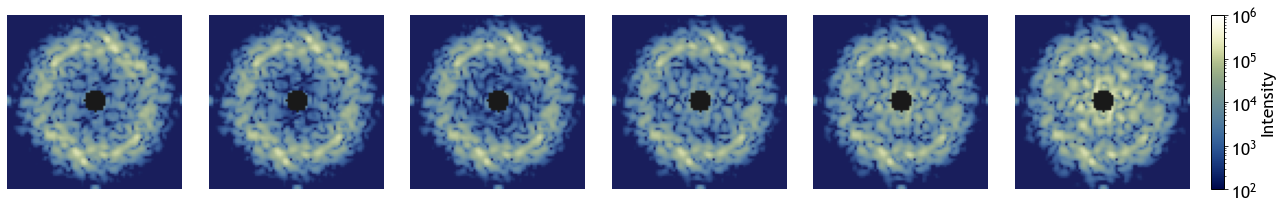

In [47]:
fig = grayscott.plot_series(batch_Y[:,0].cpu().numpy().reshape(-1,cxs.n,cxs.n),
                            ntype='log', vmin=1e2, vmax=1e6, clabel='Intensity');

### Lotka-Volterra

Detector: 92 x 92 	Probe: 15 x 15
Detector: 92 x 92 	Probe: 9 x 9
Detector: 92 x 92 	Probe: 7 x 7
Detector: 92 x 92 	Probe: 5 x 5
Detector: 80 x 80 	Probe: 13 x 13
Detector: 80 x 80 	Probe: 7 x 7
Detector: 80 x 80 	Probe: 5 x 5
Detector: 80 x 80 	Probe: 5 x 5
Detector: 72 x 72 	Probe: 11 x 11
Detector: 72 x 72 	Probe: 7 x 7
Detector: 72 x 72 	Probe: 5 x 5
Detector: 72 x 72 	Probe: 5 x 5
Detector: 65 x 65 	Probe: 10 x 10
Detector: 65 x 65 	Probe: 6 x 6
Detector: 65 x 65 	Probe: 4 x 4
Detector: 65 x 65 	Probe: 4 x 4


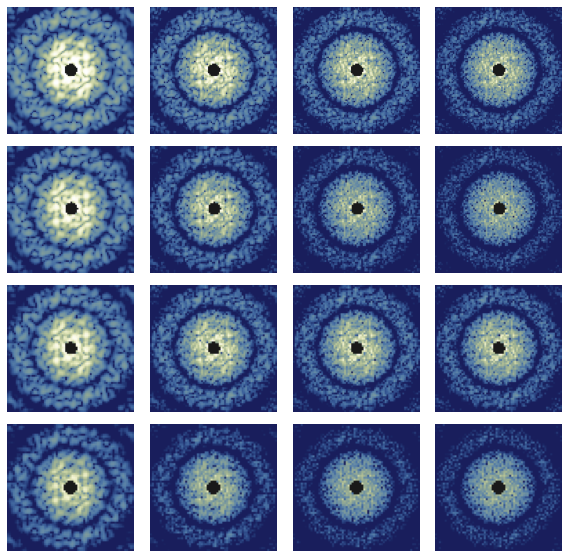

In [105]:
n = 64
f_mask = 0.05
dqs = np.arange(0.7,1.05,0.1)
f_probes = np.arange(0.15,0.5,0.1)

fig, ax = plt.subplots(len(dqs), len(f_probes), figsize=(10,10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for i, dq in enumerate(dqs):
    for j, f_probe in enumerate(f_probes):     
        cxs = CXSPoint(lv.R, n, L=lv.L, dq=dq, f_probe=f_probe, f_mask=f_mask).to(device)
        lv.plot_frame(ax[i,j], cxs(lv.y0[0]).reshape(cxs.n, cxs.n), vmin=1, vmax=1e4, ntype='log')

Detector: 80 x 80 	Probe: 13 x 13


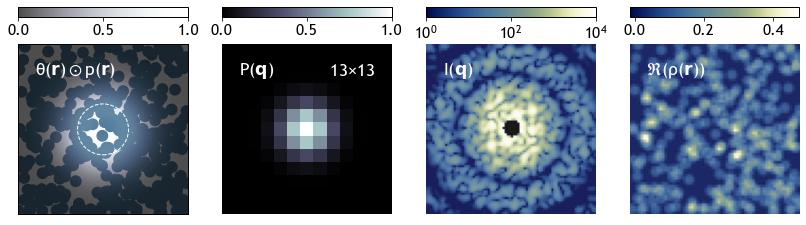

In [106]:
n = 64
dq = 0.8
f_probe = 0.15
f_mask = 0.05
cxs = CXSPoint(lv.R, n, L=lv.L, dq=dq, f_probe=f_probe, f_mask=f_mask).to(device)
fig = cxs.plot_example(lv, lv.y0[0], ntype='none', vmin=1, vmax=1e4)

In [55]:
batch_time = 20
batch_size = 10
batch_t, batch_y0, batch_y = lv.get_batch(batch_time, batch_size)
print(' t:', batch_t.shape)
print('y0:', batch_y0.shape)
print(' y:', batch_y.shape)

cxs(batch_y)
ti = time.time()
batch_Y = cxs(batch_y)
tf = time.time()
print('Elapsed time: {:.3f} s'.format(tf - ti))

 t: torch.Size([20])
y0: torch.Size([10, 400, 2])
 y: torch.Size([20, 10, 400, 2])
Elapsed time: 2.639 s


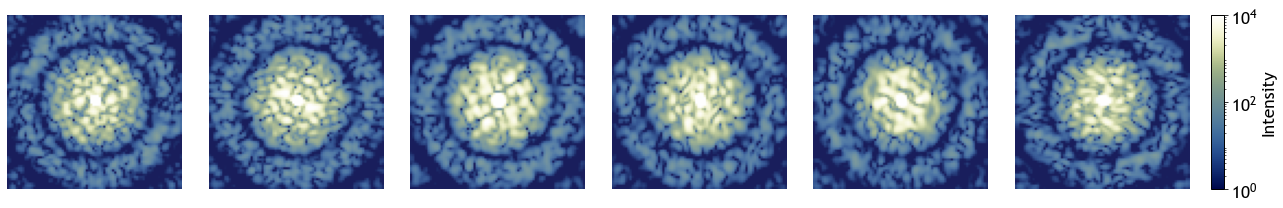

In [56]:
fig = lv.plot_series(batch_Y[:,0].cpu().numpy().reshape(-1,cxs.n,cxs.n),
                     ntype='log', vmin=1, vmax=1e4, clabel='Intensity');

In [ ]:
class NODE(ODE):
    r"""Class to define, initialize, solve, and visualize the Kuramoto model of coupled oscillators:
    
    .. math::
        :nowrap:
        
        \begin{eqnarray*}
        \frac{d\theta_i}{dt} = \omega + K\sum_{j\in N(i)}\sin(\theta_j-\theta_i)
        \end{eqnarray*}

    Parameters
    ----------
    args : dict
        Dictionary of parameters defining the ODE system:
        
            - **N** (`int`) -- Dimension of the simulation box ``(N x N)``
            - **L** (`float`) -- Length of the real-space simulation box ``(L x L)``
            - **v** (`float`) -- Intrinsic frequency of the oscillators
            - **K** (`float`) -- Coupling strength

    method : str
        Name of ODE solver to use. Default is ``dopri5``.
        
    default_type: type
        Set the default ``torch.Tensor`` type.

    Attributes
    ----------
    conv : ``torch.nn.Conv2d``
        Convolution operator coupling neighboring oscillators.

    """
    def __init__(self, args, method='dopri5', adjoint=False, default_type=torch.float64):   
        super(NODE, self).__init__(method, adjoint, requires_grad)
        
        default_args = {'N': 100,
                        'v': 0.5,
                        'K': 0.2
                       }
        
        for k, v in default_args.items():
            setattr(self, k, args[k] if k in args else v)
        
        self.conv = nn.Conv2d(1, 1, 5, bias=False, padding='same', padding_mode='circular')
        nn.init.normal_(self.conv.weight, mean=0, std=0.1)
    
    
    def forward(self, t, y):
        r"""Evaluate the ODE system at a specified time ``t`` and state ``y``.
            
        Parameters
        ----------
        t : ``torch.tensor``
            1-dimensional tensor of the evaluation time point.
        
        y : ``torch.tensor`` of shape ``(M,1,D)``
            State of the system for ``M`` initial conditions. ``D`` denotes the flattened system size.
                
        Returns
        -------
        dy/dt : ``torch.tensor`` of shape ``(M,1,D)``
            Derivative of the system.
                
        """
        y = y.view((-1, 1, self.N, self.N))
        cosy = torch.cos(y)
        siny = torch.sin(y)
        conv_cosy = self.conv(cosy)
        conv_siny = self.conv(siny)
        return self.v + self.K*(cosy*conv_siny - siny*conv_cosy).flatten(start_dim=-2)

In [ ]:
method = 'dopri5'
adjoint = False
niters = 500
test_freq = 10